In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Chemin du fichier ZIP et dossier de destination
zip_path = "/content/drive/MyDrive/kaggle/chest-xray-pneumonia.zip"
extract_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data"  # Dossier où extraire les données

# Vérifier si le fichier ZIP existe et le décompresser
try:
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Fichier {zip_path} décompressé avec succès dans {extract_path}.")
    else:
        print(f"Le fichier {zip_path} n'existe pas.")
except Exception as e:
    print(f"Erreur lors de la décompression : {e}")

Fichier /content/drive/MyDrive/kaggle/chest-xray-pneumonia.zip décompressé avec succès dans /content/drive/MyDrive/Pneumonia_Project/pneumonia_data.


In [ ]:
import os
import glob

# Chemin de base du dataset
base_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray"

# Liste des ensembles et conditions
splits = ['train', 'val', 'test']
conditions = ['NORMAL', 'PNEUMONIA']

# Dictionnaire pour stocker les comptages
data_summary = {split: {condition: 0 for condition in conditions} for split in splits}

# Compter les images
for split in splits:
    for condition in conditions:
        folder = os.path.join(base_path, split, condition)
        image_files = glob.glob(os.path.join(folder, "*.jpeg")) + glob.glob(os.path.join(folder, "*.jpg"))
        data_summary[split][condition] = len(image_files)

# Afficher un résumé
print("Résumé du dataset :")
for split in splits:
    print(f"\nEnsemble : {split}")
    for condition in conditions:
        count = data_summary[split][condition]
        print(f"  {condition} : {count} images")
    total = sum(data_summary[split].values())
    normal_ratio = data_summary[split]['NORMAL'] / total if total > 0 else 0
    pneumonia_ratio = data_summary[split]['PNEUMONIA'] / total if total > 0 else 0
    print(f"  Total : {total} images")
    print(f"  Ratio Normal/Pneumonia : {normal_ratio:.2f}/{pneumonia_ratio:.2f}")

# Recommandation pour l'augmentation
for split in splits:
    total = sum(data_summary[split].values())
    normal_count = data_summary[split]['NORMAL']
    pneumonia_count = data_summary[split]['PNEUMONIA']
    if total < 100:
        print(f"\nAvertissement : L'ensemble {split} a trop peu d'images ({total}). Une augmentation est recommandée.")
    if abs(normal_count - pneumonia_count) / total > 0.3:
        print(f"\nAvertissement : L'ensemble {split} est déséquilibré (Normal: {normal_count}, Pneumonia: {pneumonia_count}). Une augmentation est recommandée.")

Résumé du dataset :

Ensemble : train
  NORMAL : 1356 images
  PNEUMONIA : 3875 images
  Total : 5231 images
  Ratio Normal/Pneumonia : 0.26/0.74

Ensemble : val
  NORMAL : 8 images
  PNEUMONIA : 8 images
  Total : 16 images
  Ratio Normal/Pneumonia : 0.50/0.50

Ensemble : test
  NORMAL : 234 images
  PNEUMONIA : 390 images
  Total : 624 images
  Ratio Normal/Pneumonia : 0.38/0.62

Avertissement : L'ensemble train est déséquilibré (Normal: 1356, Pneumonia: 3875). Une augmentation est recommandée.

Avertissement : L'ensemble val a trop peu d'images (16). Une augmentation est recommandée.


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import Sequence
import os
import glob
import pickle

In [ ]:
try:
    with open("/content/drive/MyDrive/Pneumonia_Project/imagenet-classes.pkl", "rb") as f:
        imagenet_classes = pickle.load(f)
    print("Fichier imagenet-classes.pkl chargé avec succès.")
    print(f"Nombre de classes : {len(imagenet_classes)}")
except Exception as e:
    print(f"Erreur lors du chargement du fichier imagenet-classes.pkl : {e}")
    exit()

Fichier imagenet-classes.pkl chargé avec succès.
Nombre de classes : 1000


In [ ]:
try:
    model = VGG16(weights='imagenet', include_top=True)
    print("Modèle VGG16 chargé avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle : {e}")
    exit()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Modèle VGG16 chargé avec succès.


In [ ]:
import os
import glob
from PIL import Image
import numpy as np
from skimage import exposure

# Chemins
base_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray"
new_base_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4"

# Créer le nouveau dossier pour les images retraitées
if not os.path.exists(new_base_path):
    os.makedirs(new_base_path)

# Liste des ensembles et conditions
splits = ['train', 'val', 'test']
conditions = ['NORMAL', 'PNEUMONIA']

# Fonction pour traiter une image avec égalisation d'histogramme
def process_and_save_image(image_path, output_path):
    # Charger l'image en grayscale
    img = Image.open(image_path).convert('L')
    img_array = np.array(img, dtype=np.float32)

    # Normaliser les valeurs entre 0 et 1 pour l'égalisation
    img_array = img_array / 255.0

    # Appliquer l'égalisation d'histogramme
    img_array = exposure.equalize_hist(img_array)

    # Remettre les valeurs entre 0 et 255
    img_array = (img_array * 255).astype(np.uint8)

    # Convertir en image PIL
    img = Image.fromarray(img_array)

    # Redimensionner à 224x224
    img = img.resize((224, 224), Image.BILINEAR)

    # Convertir en tableau NumPy pour simuler RGB
    img_array = np.array(img, dtype=np.float32)
    img_array = np.stack([img_array, img_array, img_array], axis=-1)  # Dupliquer pour RGB
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)  # Assurer que les valeurs sont entre 0 et 255

    # Sauvegarder l'image traitée
    processed_img = Image.fromarray(img_array)
    processed_img.save(output_path)

# Traiter et sauvegarder toutes les images
for split in splits:
    for condition in conditions:
        # Dossier d'entrée (images originales et augmentées)
        input_folder = os.path.join(base_path, split, condition)
        # Dossier de sortie (images retraitées)
        output_folder = os.path.join(new_base_path, split, condition)
        os.makedirs(output_folder, exist_ok=True)

        # Lister toutes les images
        image_files = glob.glob(os.path.join(input_folder, "*.jpeg")) + glob.glob(os.path.join(input_folder, "*.jpg"))

        print(f"\nTraitement du dossier : {input_folder}")
        for img_path in image_files:
            img_name = os.path.basename(img_path)
            output_path = os.path.join(output_folder, img_name)
            process_and_save_image(img_path, output_path)
        print(f"Nombre d'images traitées dans {input_folder} : {len(image_files)}")

print("\nTraitement terminé. Les images retraitées sont dans :", new_base_path)


Traitement du dossier : /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray/train/NORMAL
Nombre d'images traitées dans /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray/train/NORMAL : 3875

Traitement du dossier : /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray/train/PNEUMONIA
Nombre d'images traitées dans /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray/train/PNEUMONIA : 3875

Traitement du dossier : /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray/val/NORMAL
Nombre d'images traitées dans /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray/val/NORMAL : 50

Traitement du dossier : /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray/val/PNEUMONIA
Nombre d'images traitées dans /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray/val/PNEUMONIA : 50

Traitement du dossier : /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray/test/NORMAL
Nombre d

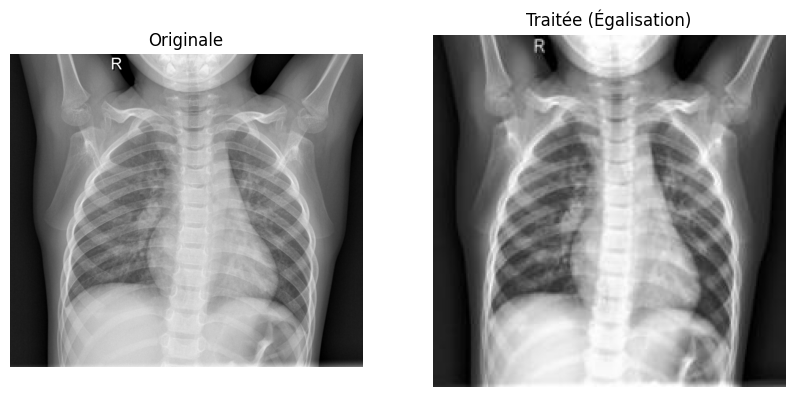

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Chemin d'une image originale et son équivalent traité
original_img_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray/train/NORMAL/IM-0115-0001.jpeg"
processed_img_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4/train/NORMAL/IM-0115-0001.jpeg"

# Charger les images
original_img = Image.open(original_img_path)
processed_img = Image.open(processed_img_path)

# Afficher côte à côte
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Originale")
plt.imshow(original_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Traitée (Égalisation)")
plt.imshow(processed_img)
plt.axis('off')

plt.show()


In [ ]:
import os
import glob

# Chemins des dossiers
processed_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4"
original_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray"

# Liste des ensembles et conditions
splits = ['train', 'val', 'test']
conditions = ['NORMAL', 'PNEUMONIA']

# Fonction pour compter les images augmentées et totales dans un dossier
def count_images(base_path, dataset_name):
    total_images = 0
    total_augmented = 0
    augmented_locations = {}

    for split in splits:
        for condition in conditions:
            folder = os.path.join(base_path, split, condition)
            # Lister toutes les images (jpeg ou jpg)
            image_files = glob.glob(os.path.join(folder, "*.jpeg")) + glob.glob(os.path.join(folder, "*.jpg"))

            # Compter les images augmentées (contenant "aug_" dans le nom)
            augmented_images = [img for img in image_files if "aug_" in os.path.basename(img)]

            # Mettre à jour les compteurs
            total_images += len(image_files)
            total_augmented += len(augmented_images)

            # Enregistrer les emplacements des images augmentées
            if augmented_images:
                augmented_locations[f"{split}/{condition}"] = len(augmented_images)

    return total_images, total_augmented, augmented_locations

# Compter les images dans chest_xray_processed_v4
total_processed, total_augmented_processed, augmented_locations_processed = count_images(processed_path, "chest_xray_processed_v4")

# Compter les images dans chest_xray
total_original, total_augmented_original, augmented_locations_original = count_images(original_path, "chest_xray")

# Afficher les résultats
print("=== Analyse de chest_xray_processed_v4 ===")
print(f"Nombre total d'images : {total_processed}")
print(f"Nombre total d'images augmentées : {total_augmented_processed}")
if total_augmented_processed > 0:
    print("Emplacements des images augmentées :")
    for location, count in augmented_locations_processed.items():
        print(f"  {location} : {count} images augmentées")
else:
    print("Aucune image augmentée trouvée dans chest_xray_processed_v4")

print("\n=== Analyse de chest_xray ===")
print(f"Nombre total d'images : {total_original}")
print(f"Nombre total d'images augmentées : {total_augmented_original}")
if total_augmented_original > 0:
    print("Emplacements des images augmentées :")
    for location, count in augmented_locations_original.items():
        print(f"  {location} : {count} images augmentées")
else:
    print("Aucune image augmentée trouvée dans chest_xray")

print("\n=== Comparaison ===")
print(f"Différence dans le nombre total d'images (processed_v4 - original) : {total_processed - total_original}")
print(f"Différence dans le nombre d'images augmentées (processed_v4 - original) : {total_augmented_processed - total_augmented_original}")

=== Analyse de chest_xray_processed_v4 ===
Nombre total d'images : 8474
Nombre total d'images augmentées : 2618
Emplacements des images augmentées :
  train/NORMAL : 2534 images augmentées
  val/NORMAL : 42 images augmentées
  val/PNEUMONIA : 42 images augmentées

=== Analyse de chest_xray ===
Nombre total d'images : 8474
Nombre total d'images augmentées : 2618
Emplacements des images augmentées :
  train/NORMAL : 2534 images augmentées
  val/NORMAL : 42 images augmentées
  val/PNEUMONIA : 42 images augmentées

=== Comparaison ===
Différence dans le nombre total d'images (processed_v4 - original) : 0
Différence dans le nombre d'images augmentées (processed_v4 - original) : 0


Visualisation des images dans chest_xray_processed_v4 :


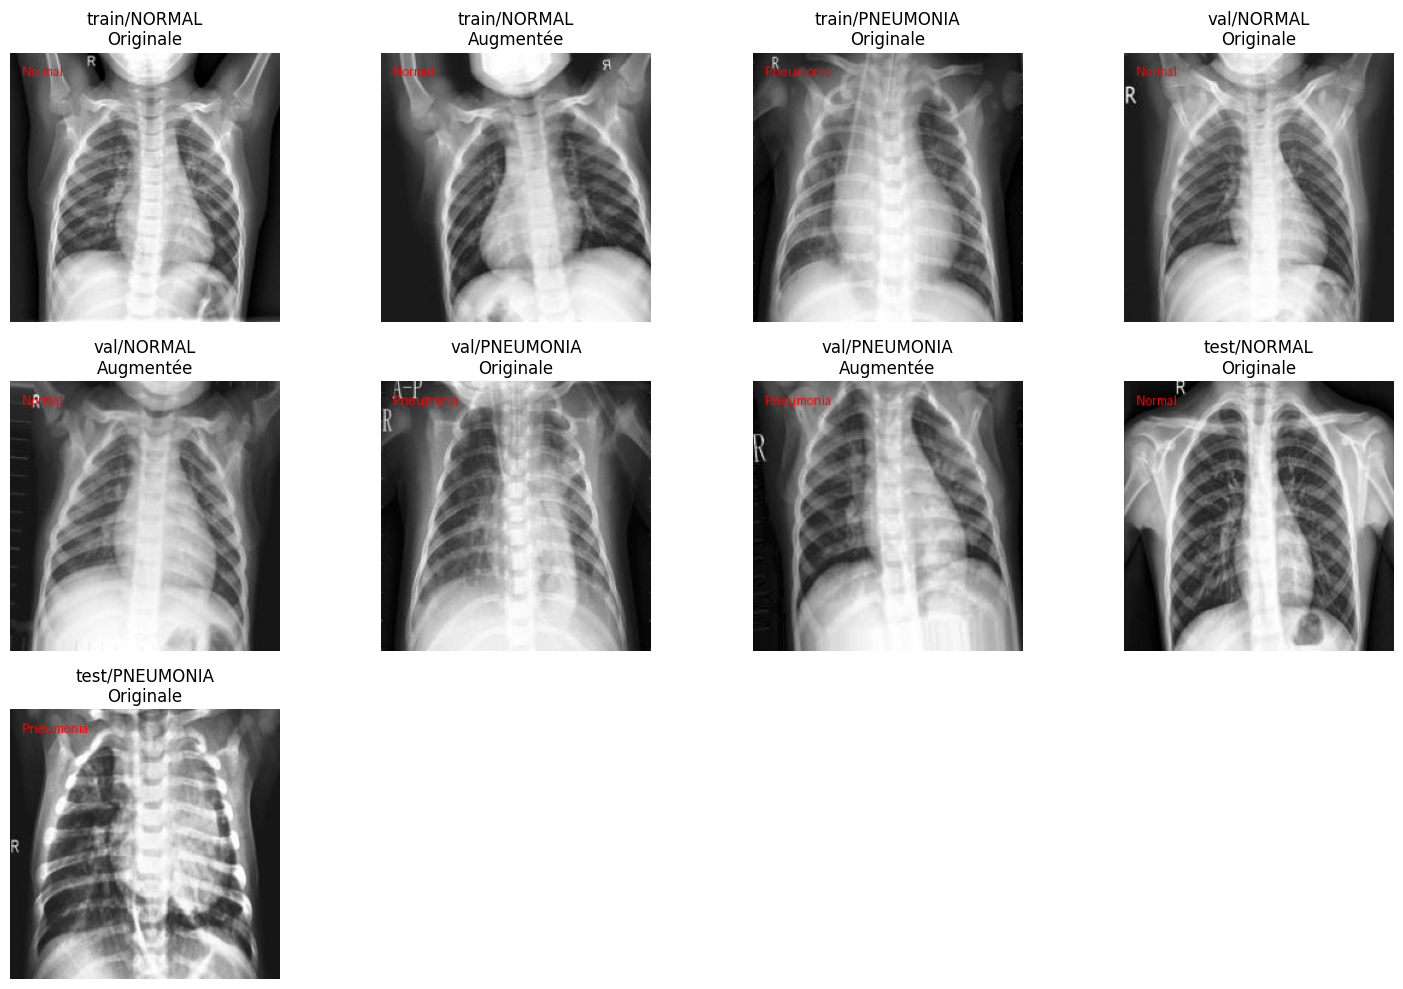


Fichier imagenet-classes.pkl chargé avec succès.
Nombre de classes : 1000
553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step
Modèle VGG16 chargé avec succès.


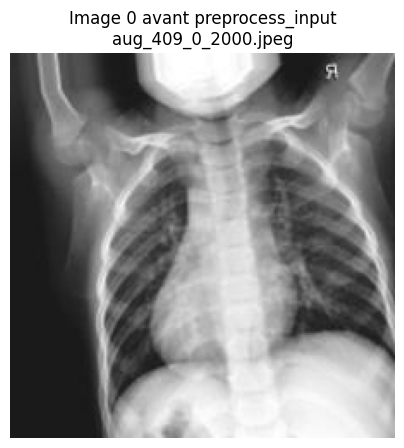

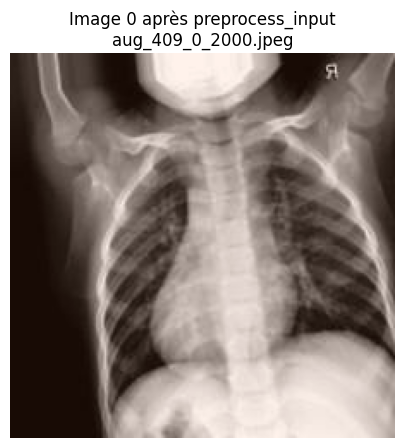


Traitement de l'image : /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4/train/NORMAL/aug_409_0_2000.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classe prédite : conch, Confiance : 0.6832


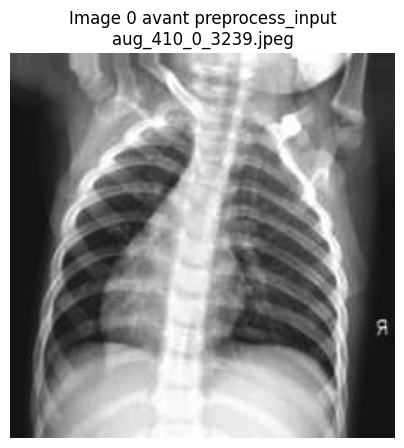

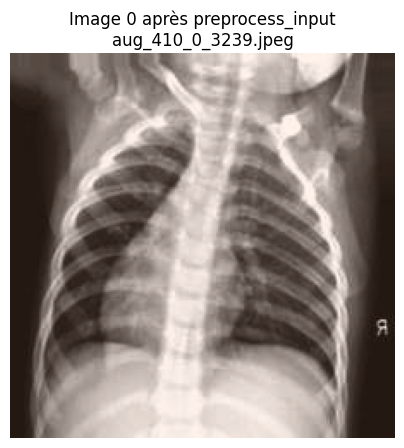


Traitement de l'image : /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4/train/NORMAL/aug_410_0_3239.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Classe prédite : conch, Confiance : 0.1746


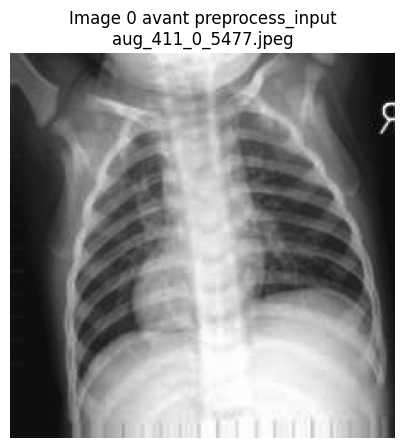

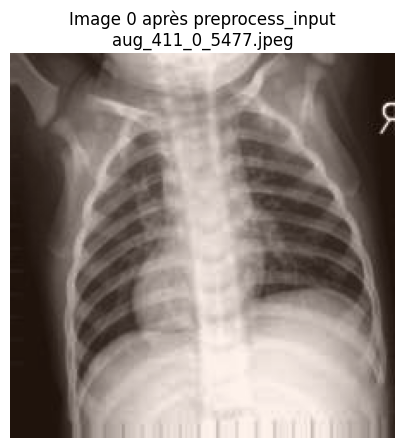


Traitement de l'image : /content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4/train/NORMAL/aug_411_0_5477.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classe prédite : conch, Confiance : 0.3844


In [ ]:
import os
import glob
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import Sequence
import pickle

# Partie 1 : Visualisation des images dans chest_xray_processed_v4
# Chemin du dossier traité
base_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4"

# Liste des ensembles et conditions
splits = ['train', 'val', 'test']
conditions = ['NORMAL', 'PNEUMONIA']

# Fonction pour visualiser les images avec labels
def visualize_processed_images():
    plt.figure(figsize=(15, 10))  # Taille de la figure
    plot_idx = 1  # Index pour les sous-graphiques

    for split in splits:
        for condition in conditions:
            folder = os.path.join(base_path, split, condition)
            image_files = glob.glob(os.path.join(folder, "*.jpeg")) + glob.glob(os.path.join(folder, "*.jpg"))

            # Séparer images originales et augmentées
            original_images = [img for img in image_files if not "aug_" in os.path.basename(img)]
            augmented_images = [img for img in image_files if "aug_" in os.path.basename(img)]

            # Prendre 1 image originale et 1 augmentée (si elles existent)
            images_to_show = []
            if original_images:
                images_to_show.append((original_images[0], "Originale"))
            if augmented_images:
                images_to_show.append((augmented_images[0], "Augmentée"))

            # Afficher les images
            for img_path, img_type in images_to_show:
                img = Image.open(img_path)  # Charger l'image sans convertir en grayscale
                # Ajouter un label directement sur l'image
                draw = ImageDraw.Draw(img)
                try:
                    font = ImageFont.load_default()
                except:
                    font = ImageFont.load_default()

                label = condition.capitalize()
                draw.text((10, 10), label, fill=255, font=font)  # Écrire en blanc en haut à gauche

                img_array = np.array(img, dtype=np.float32)

                # Afficher l'image
                plt.subplot(len(splits), len(conditions) * 2, plot_idx)
                plt.imshow(img_array.astype(np.uint8))  # Pas de cmap='gray', car l'image est en RGB
                plt.title(f"{split}/{condition}\n{img_type}")
                plt.axis('off')  # Cacher les axes
                plot_idx += 1

    plt.tight_layout()
    plt.show()

# Exécuter la visualisation
print("Visualisation des images dans chest_xray_processed_v4 :")
visualize_processed_images()

# Partie 2 : Étape 6 - Inférence avec VGG16 (corrigée)
# Étape 1 : Charger le fichier imagenet-classes.pkl
try:
    with open("/content/drive/MyDrive/Pneumonia_Project/imagenet-classes.pkl", "rb") as f:
        imagenet_classes = pickle.load(f)
    print("\nFichier imagenet-classes.pkl chargé avec succès.")
    print(f"Nombre de classes : {len(imagenet_classes)}")
except Exception as e:
    print(f"Erreur lors du chargement du fichier imagenet-classes.pkl : {e}")
    exit()

# Étape 2 : Charger le modèle VGG16
try:
    model = VGG16(weights='imagenet', include_top=True)
    print("Modèle VGG16 chargé avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle : {e}")
    exit()

# Étape 3 : Définir un générateur personnalisé
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, batch_size, img_size=(224, 224), shuffle=False):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in indices]
        batch_images = [self.preprocess_image(path, i) for i, path in enumerate(batch_paths)]
        return np.array(batch_images)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def preprocess_image(self, image_path, idx):
        # Charger l'image directement (elle est déjà en RGB et prétraitée)
        img = Image.open(image_path)
        img_array = np.array(img, dtype=np.float32)

        # Visualisation avant preprocess_input (pour vérifier l'image brute)
        plt.figure(figsize=(5, 5))
        plt.imshow(img_array.astype(np.uint8))  # Afficher l'image brute (en RGB)
        plt.title(f"Image {idx} avant preprocess_input\n{os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()

        # Appliquer preprocess_input pour VGG16
        img_array = preprocess_input(img_array)  # Normalisation ImageNet

        # Visualisation après preprocess_input
        # Remettre les valeurs dans une plage affichable (0 à 255) pour la visualisation
        img_to_display = img_array - img_array.min()  # Déplacer le minimum à 0
        img_to_display = (img_to_display / img_to_display.max() * 255).astype(np.uint8)  # Normaliser à 0-255
        plt.figure(figsize=(5, 5))
        plt.imshow(img_to_display)  # Pas de cmap='gray', car l'image est en RGB
        plt.title(f"Image {idx} après preprocess_input\n{os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()

        return img_array

# Étape 4 : Charger les chemins des images (nouveau dossier traité)
base_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4"
splits = ['train', 'val', 'test']
conditions = ['NORMAL', 'PNEUMONIA']
image_paths = []

for split in splits:
    for condition in conditions:
        folder = os.path.join(base_path, split, condition)
        paths = glob.glob(os.path.join(folder, "*.jpeg")) + glob.glob(os.path.join(folder, "*.jpg"))
        image_paths.extend(paths)

# Limiter à 3 images pour tester
image_paths = image_paths[:3]

# Étape 5 : Créer le générateur et faire l'inférence
batch_size = 1  # Traiter une image à la fois pour simplifier
generator = CustomDataGenerator(image_paths, batch_size, shuffle=False)

for i in range(len(generator)):
    batch_images = generator[i]
    image_path = image_paths[i]
    print(f"\nTraitement de l'image : {image_path}")

    try:
        # Ajouter une dimension batch si nécessaire
        if len(batch_images.shape) == 3:
            batch_images = np.expand_dims(batch_images, axis=0)

        # Faire l'inférence
        predictions = model.predict(batch_images)
        predicted_class_idx = np.argmax(predictions, axis=1)[0]
        confidence = np.max(predictions, axis=1)[0]

        # Récupérer le nom de la classe
        if isinstance(imagenet_classes, dict):
            predicted_class = imagenet_classes[predicted_class_idx][1]  # Prendre le nom (deuxième élément du tuple)
        else:
            predicted_class = imagenet_classes[predicted_class_idx]

        print(f"Classe prédite : {predicted_class}, Confiance : {confidence:.4f}")
    except Exception as e:
        print(f"Erreur lors de l'inférence pour {image_path} : {e}")

In [ ]:

import os
import glob
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
import time

# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Définir les chemins
base_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4"
splits = ['train', 'val', 'test']
conditions = ['NORMAL', 'PNEUMONIA']
save_path = "/content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5"

# Vérifier et charger le modèle existant ou créer un nouveau
if os.path.exists(save_path):
    model = load_model(save_path)
    print(f"Modèle chargé à partir de : {save_path}")
    # Déterminer l'epoch initiale (approximation, à ajuster manuellement si logs disponibles)
    initial_epoch = 0  # Remplace par la dernière epoch connue si tu as les logs
else:
    # Étape 1 : Charger VGG16 sans la couche finale
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    print("VGG16 chargé avec succès (sans couche finale).")

    # Étape 2 : Geler les couches convolutives
    for layer in base_model.layers:
        layer.trainable = False
    print("Couches convolutives gelées.")

    # Étape 3 : Ajouter de nouvelles couches de classification
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model)

    # Créer le modèle final
    model = Model(inputs=base_model.input, outputs=top_model)
    print("Nouvelles couches ajoutées pour classification binaire.")
    initial_epoch = 0

# Étape 4 : Préparer les données
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, img_size=(224, 224), shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in indices]
        batch_labels = [self.labels[i] for i in indices]
        batch_images = [self.preprocess_image(path) for path in batch_paths]
        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def preprocess_image(self, image_path):
        img = Image.open(image_path)
        img_array = np.array(img, dtype=np.float32)
        return preprocess_input(img_array)

# Charger les chemins et labels
generators = {}
for split in splits:
    image_paths = []
    labels = []
    for condition in conditions:
        folder = os.path.join(base_path, split, condition)
        paths = glob.glob(os.path.join(folder, "*.jpeg")) + glob.glob(os.path.join(folder, "*.jpg"))
        image_paths.extend(paths)
        labels.extend([0 if condition == 'NORMAL' else 1] * len(paths))
    generators[split] = CustomDataGenerator(image_paths, labels, batch_size=32, shuffle=(split == 'train'))
    print(f"Générateur créé pour {split} : {len(image_paths)} images.")

# Étape 5 : Compiler et entraîner
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Modèle compilé.")

# Callback pour sauvegarde automatique à chaque epoch
checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=False, save_freq='epoch', verbose=1)
print("Callback ModelCheckpoint ajouté pour sauvegarde à chaque epoch.")

# Entraîner le modèle avec sauvegardes manuelles tous les 2-3 epochs
history = model.fit(
    generators['train'],
    validation_data=generators['val'],
    epochs=10,
    initial_epoch=initial_epoch,
    verbose=1,
    callbacks=[checkpoint]
)

# Sauvegardes manuelles tous les 2-3 epochs
for epoch in range(initial_epoch, 10):
    if (epoch + 1) % 2 == 0 or (epoch + 1) % 3 == 0:  # Sauvegarde à 2, 3, 4, 6, 7, 8, 9, 10
        manual_save_path = f"/content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model_epoch_{epoch+1}.h5"
        model.save(manual_save_path)
        print(f"Sauvegarde manuelle effectuée à : {manual_save_path}")

print("Entraînement terminé.")

# Sauvegarde finale
model.save(save_path)
print(f"Modèle sauvegardé à : {save_path}")

# Évaluer sur le test
test_loss, test_accuracy = model.evaluate(generators['test'], verbose=1)
print(f"Accuracy sur test : {test_accuracy:.4f}")

# Visualiser les prédictions
test_images, test_labels = generators['test'][0]
predictions = model.predict(test_images)

class_names = ['Normal', 'Pneumonia']
for i in range(min(5, len(test_images))):
    predicted_class = 1 if predictions[i][0] > 0.5 else 0
    true_class = test_labels[i]
    print(f"Image {i} - Prédiction : {class_names[predicted_class]}, Vrai label : {class_names[true_class]}")

# Prévenir la déconnexion : Script simple pour garder Colab actif
def keep_alive():
    while True:
        print("Maintenant Colab actif...")
        time.sleep(600)  # Rafraîchir toutes les 10 minutes

# Lancer le script en arrière-plan (commenté pour ne pas bloquer, à activer si besoin)
import threading
threading.Thread(target=keep_alive, daemon=True).start()
print("Pour éviter les déconnexions, active le script 'keep_alive' avec threading ou utilise une extension comme 'Colab Keep Alive'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 chargé avec succès (sans couche finale).
Couches convolutives gelées.
Nouvelles couches ajoutées pour classification binaire.
Générateur créé pour train : 7750 images.
Générateur créé pour val : 100 images.
Générateur créé pour test : 624 images.
Modèle compilé.
Callback ModelCheckpoint ajouté pour sauvegarde à chaque epoch.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.8414 - loss: 0.7534 
Epoch 1: saving model to /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 4463s 18s/step - accuracy: 0.8416 - loss: 0.7516 - val_accuracy: 0.8500 - val_loss: 0.3430
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9559 - loss: 0.1274 
Epoch 2: saving model to /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 4195s 17s/step - accuracy: 0.9559 - loss: 0.1273 - val_accuracy: 0.7500 - val_loss: 0.6876
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9710 - loss: 0.0807 
Epoch 3: saving model to /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 4109s 17s/step - accuracy: 0.9710 - loss: 0.0808 - val_accuracy: 0.8000 - val_loss: 0.4550
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9711 - loss: 0.0823 
Epoch 4: saving model to /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 4140s 17s/step - accuracy: 0.9711 - loss: 0.0823 - val_accuracy: 0.7600 - val_loss: 0.7904
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9724 - loss: 0.0721 
Epoch 5: saving model to /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 4132s 17s/step - accuracy: 0.9724 - loss: 0.0721 - val_accuracy: 0.7700 - val_loss: 0.6124
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9787 - loss: 0.0650 
Epoch 6: saving model to /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 4289s 17s/step - accuracy: 0.9787 - loss: 0.0650 - val_accuracy: 0.7400 - val_loss: 0.9009
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9781 - loss: 0.0618 
Epoch 7: saving model to /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 4234s 17s/step - accuracy: 0.9781 - loss: 0.0618 - val_accuracy: 0.7800 - val_loss: 0.6413
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9788 - loss: 0.0534 
Epoch 8: saving model to /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 4203s 17s/step - accuracy: 0.9787 - loss: 0.0535 - val_accuracy: 0.7700 - val_loss: 0.7922
Epoch 9/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9794 - loss: 0.0513 
Epoch 9: saving model to /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 4227s 17s/step - accuracy: 0.9794 - loss: 0.0514 - val_accuracy: 0.6800 - val_loss: 0.9452
Epoch 10/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9804 - loss: 0.0531 
Epoch 10: saving model to /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 4218s 17s/step - accuracy: 0.9804 - loss: 0.0532 - val_accuracy: 0.7500 - val_loss: 1.3820


Sauvegarde manuelle effectuée à : /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model_epoch_2.h5


Sauvegarde manuelle effectuée à : /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model_epoch_3.h5


Sauvegarde manuelle effectuée à : /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model_epoch_4.h5


Sauvegarde manuelle effectuée à : /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model_epoch_6.h5


Sauvegarde manuelle effectuée à : /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model_epoch_8.h5


Sauvegarde manuelle effectuée à : /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model_epoch_9.h5


Sauvegarde manuelle effectuée à : /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model_epoch_10.h5
Entraînement terminé.
Modèle sauvegardé à : /content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 344s 17s/step - accuracy: 0.6872 - loss: 2.0068
Accuracy sur test : 0.8157
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
Image 0 - Prédiction : Pneumonia, Vrai label : Normal
Image 1 - Prédiction : Normal, Vrai label : Normal
Image 2 - Prédiction : Normal, Vrai label : Normal
Image 3 - Prédiction : Normal, Vrai label : Normal
Image 4 - Prédiction : Normal, Vrai label : Normal
Maintenant Colab actif...
Pour éviter les déconnexions, active le script 'keep_alive' avec threading ou utilise une extension comme 'Colab Keep Alive'.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Modèle chargé avec succès.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step


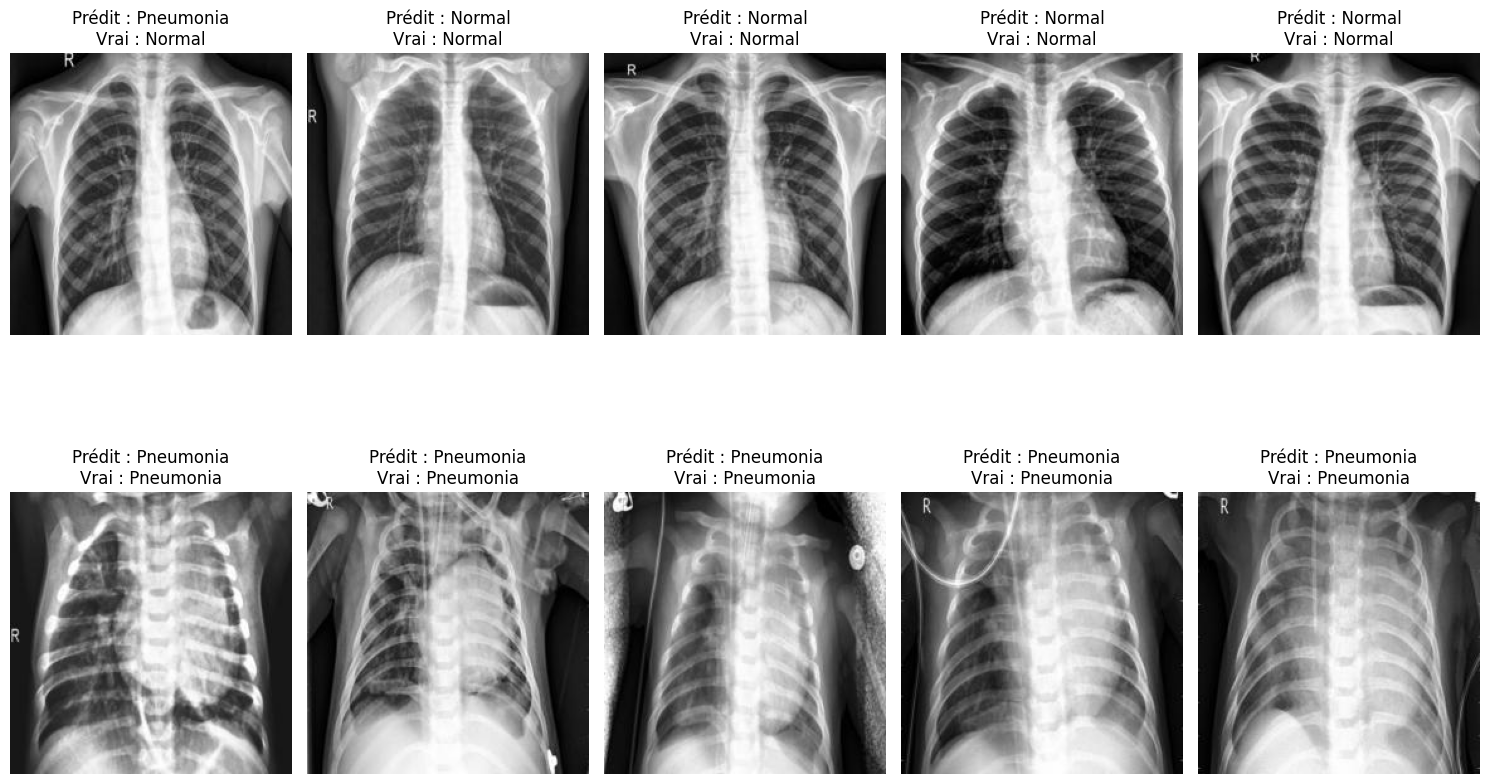

In [ ]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')a

# Définir les chemins
base_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4"
save_path = "/content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5"

# Charger le modèle
model = load_model(save_path)
print("Modèle chargé avec succès.")

# Charger quelques images de test
test_image_paths = []
test_labels = []
conditions = ['NORMAL', 'PNEUMONIA']
for condition in conditions:
    folder = os.path.join(base_path, 'test', condition)
    paths = glob.glob(os.path.join(folder, "*.jpeg")) + glob.glob(os.path.join(folder, "*.jpg"))
    test_image_paths.extend(paths[:5])  # Prendre 5 images par classe
    test_labels.extend([0 if condition == 'NORMAL' else 1] * 5)

# Tester et visualiser
class_names = ['Normal', 'Pneumonia']
plt.figure(figsize=(15, 10))

for i, (img_path, true_label) in enumerate(zip(test_image_paths, test_labels)):
    # Charger et prétraiter l’image
    img = Image.open(img_path)
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Faire une prédiction
    prediction = model.predict(img_array)
    predicted_class = 1 if prediction[0][0] > 0.5 else 0

    # Afficher l’image avec prédiction et vrai label
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.arr
               ay(Image.open(img_path)))
    plt.title(f"Prédit : {class_names[predicted_class]}\nVrai : {class_names[true_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Modèle chargé avec succès.
Nombre total d'images de test : 624
Accuracy globale sur le test : 0.8157

Rapport de classification :
              precision    recall  f1-score   support

      Normal       0.93      0.55      0.69       234
   Pneumonia       0.78      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.76      0.78       624
weighted avg       0.84      0.82      0.80       624


Matrice de confusion :
[[128 106]
 [  9 381]]


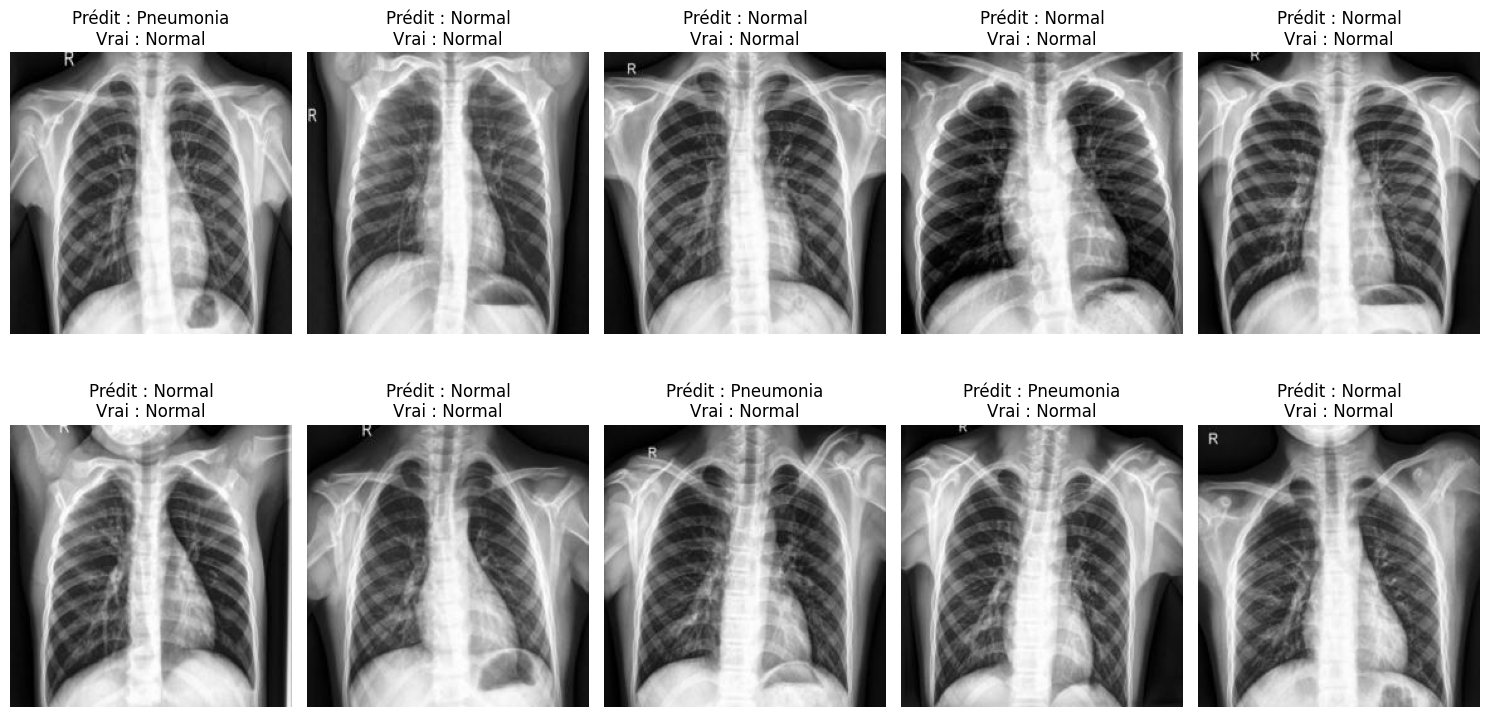

In [ ]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Définir les chemins
base_path = "/content/drive/MyDrive/Pneumonia_Project/pneumonia_data/chest_xray_processed_v4"
save_path = "/content/drive/MyDrive/Pneumonia_Project/models/vgg16_binary_model.h5"

# Charger le modèle
model = load_model(save_path)
print("Modèle chargé avec succès.")

# Charger toutes les images de test
test_image_paths = []
test_labels = []
conditions = ['NORMAL', 'PNEUMONIA']
for condition in conditions:
    folder = os.path.join(base_path, 'test', condition)
    paths = glob.glob(os.path.join(folder, "*.jpeg")) + glob.glob(os.path.join(folder, "*.jpg"))
    test_image_paths.extend(paths)
    test_labels.extend([0 if condition == 'NORMAL' else 1] * len(paths))

print(f"Nombre total d'images de test : {len(test_image_paths)}")

# Faire des prédictions sur toutes les images
predictions = []
true_labels = test_labels.copy()

for img_path in test_image_paths:
    img = Image.open(img_path)
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array, verbose=0)
    predicted_class = 1 if pred[0][0] > 0.5 else 0
    predictions.append(predicted_class)

# Calculer l'accuracy globale et afficher un rapport
accuracy = np.mean(np.array(predictions) == np.array(true_labels))
print(f"Accuracy globale sur le test : {accuracy:.4f}")

# Rapport de classification
print("\nRapport de classification :")
print(classification_report(true_labels, predictions, target_names=['Normal', 'Pneumonia']))

# Matrice de confusion
print("\nMatrice de confusion :")
print(confusion_matrix(true_labels, predictions))

# Visualiser quelques images avec leurs prédictions
class_names = ['Normal', 'Pneumonia']
num_images_to_display = 10  # Affiche 10 images pour visualisation
plt.figure(figsize=(15, 8))

for i in range(min(num_images_to_display, len(test_image_paths))):
    img_path = test_image_paths[i]
    true_label = true_labels[i]
    predicted_label = predictions[i]

    # Charger et afficher l’image
    img = Image.open(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(np.array(img))
    plt.title(f"Prédit : {class_names[predicted_label]}\nVrai : {class_names[true_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()